# TP : Entraînez-vous à entraîner un algorithme de Machine Learning !

## 1. Introduction 

### 1.1 Preprocess 

To begin with this problem, we will remove outliers (appartement costing more than 10 000€ / month), and we will remove appartement with missing value. 

In [1]:
data_path = "~/Documents/openclassroom/Fomation_ingenieur_ML/data/"

# On importe les librairies dont on aura besoin pour ce tp
import numpy as np
import pandas as pd
## plot : 
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [15, 5]
## stat / model : 
from sklearn.model_selection import train_test_split


In [2]:
### EXTRACTION DATA ###
# On charge le dataset
house_data = pd.read_csv(data_path+'house_data_complete.csv')
print(house_data.head(2),"\n")

# OUTLIERS
print("Before removing outliers, there are ", house_data.shape[0], "considered appartements")
house_data = house_data[house_data['price'] < 8000]
# plt.plot(house_data['surface'], house_data['price'], 'ro', markersize=4)
# plt.show()

## REMOVING NaNs :
print("Before removing uncomplete data (NaNs), there are ", house_data.shape[0], "considered appartements")

#house_data.dropna(axis=0, how = any) 
house_data.dropna(inplace=True) 

print("After preprocessing, there are", house_data.shape[0], "considered appartements")


   price  surface  arrondissement
0   1820     46.1             1.0
1   1750     41.0             1.0 

Before removing outliers, there are  827 considered appartements
Before removing uncomplete data (NaNs), there are  817 considered appartements
After preprocessing, there are 812 considered appartements


### 1.2 First graphical analysis
My pb : the considered arrondissement are the 1,2,3,4 and 10 -> 10 gives sad color + legend ugly
It was not that easy to tackle the legend. 

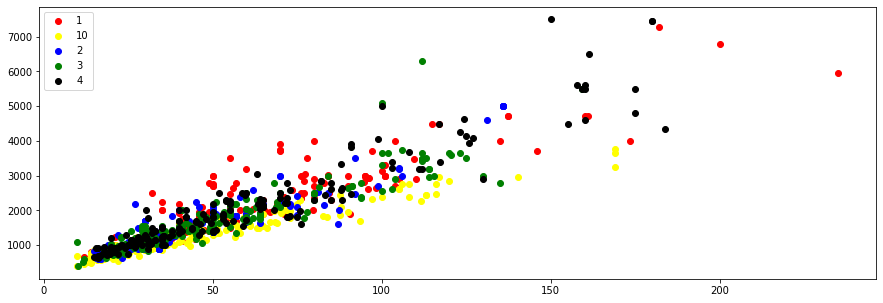

In [3]:
df = house_data.copy()
df["arr"]= df['arrondissement'].map(int).map(str)
colors = {'1':'red', '2':'blue', '3':'green', '4':'black', '10':'yellow'}
grouped = df.groupby('arr')
for key, group in grouped:
    plt.scatter(group["surface"], group["price"], label=key, color=colors[key] ) 
plt.legend()
plt.show()

We see that we have a different slopes for each arrondissement, thus it is a good idea to add this information in the linear model. Let us (as in the correction) see a boxplot in each arrondissement :

<AxesSubplot:title={'center':'surface'}, xlabel='arr'>

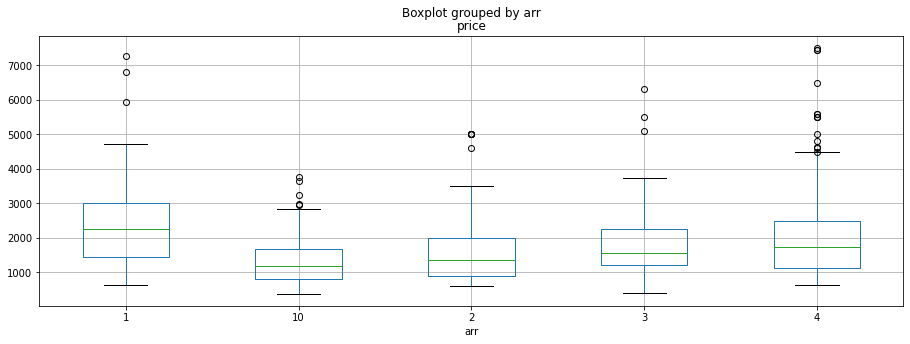

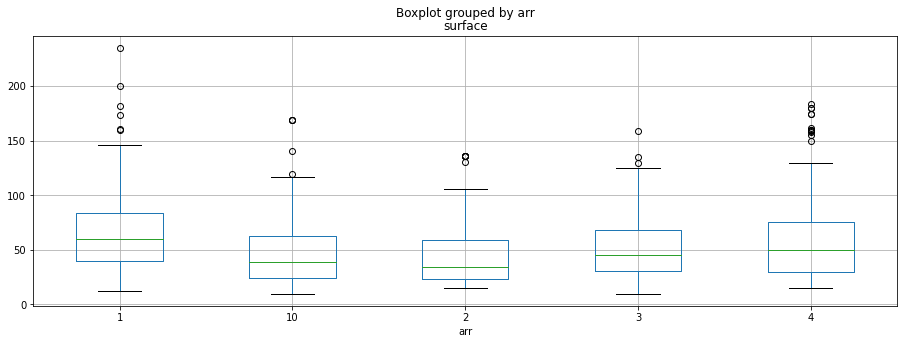

In [4]:
df.drop("arrondissement", axis=1, inplace=False).boxplot(by="arr", column="price")
df.drop("arrondissement", axis=1, inplace=False).boxplot(by="arr", column="surface")

### 1.3 Recall of Linear Regression syntaxe : 

After slipping the train and test sets, I use the sklearn method "sklearn.linear_model.LinearRegression" and train it on data, as it was done in the course :

In [5]:
X = (np.matrix([np.ones(house_data.shape[0]), house_data['surface'].values])).T
y = np.matrix(house_data['price']).T

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

## DEFINE MODEL :
from sklearn import linear_model
regr = linear_model.LinearRegression()

## TRAINING : 
regr.fit(X_train, y_train)

tmp = np.concatenate((y_test.T, regr.predict(X_test).T)).T
print( pd.DataFrame(tmp,columns=["value","pred"]).head(5) )

    value         pred
0  2500.0  1760.386966
1  1790.0  2047.908609
2  4050.0  3111.738687
3   950.0   840.317709
4   402.0   555.671283


I have change the syntax after seeing the correction : it is possible to keep the pandas stucture instead of passing in np.matrix type. 


##Remarque TODO : grosse question sur la matrice de design $X$ : est-ce qu'elle doit contenir le vecteur (1...1) en première colonne pour l'intercept ? pas clair dans les cours ...


In [6]:
X = np.matrix(house_data['surface']).T
y = house_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

## DEFINE MODEL :
from sklearn import linear_model
regr = linear_model.LinearRegression()

# ## TRAINING : 
regr.fit(X_train, y_train)

tmp = pd.DataFrame(y_test).copy()
tmp["predicted"] = regr.predict(X_test)
tmp.head(5)

,price,predicted
413,1195,1041.570986
796,1664,2225.294488
754,1360,1583.323493
551,1050,1153.815692
774,780,988.884696


## 2. One Linear Regression for each arrondissement : 

As we know that there is a different comportement in each arrondissement, instead of training one general linear regression, I will train K=5 different linear regression as : 

<center>price$_{\text{arr} k}$ = coeff$_{\text{arr} k}$ * surface + shift$_{\text{arr}k}$ </center>



In [7]:
X = house_data[['surface','arrondissement']]
y = house_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

## DEFINE MODEL :
from sklearn import linear_model
dict_regr_k = {}


## TRAINING arrondissement by arrondissement -> 5 linear regr: 
for k in np.unique(X_train["arrondissement"]):
    index_train_k = (X_train["arrondissement"]==k).index
    X_train_k = np.matrix(X_train["surface"][index_train_k]).T
    y_train_k = y_train[index_train_k]
    
    regr = linear_model.LinearRegression()
    regr.fit(X_train_k, y_train_k)
    dict_regr_k[str(int(k))]= regr
        
# tmp = pd.DataFrame(y_test).copy()
# tmp["predicted"] = regr.predict(X_test)
# tmp.head(5)

Syntaxe with groupby :

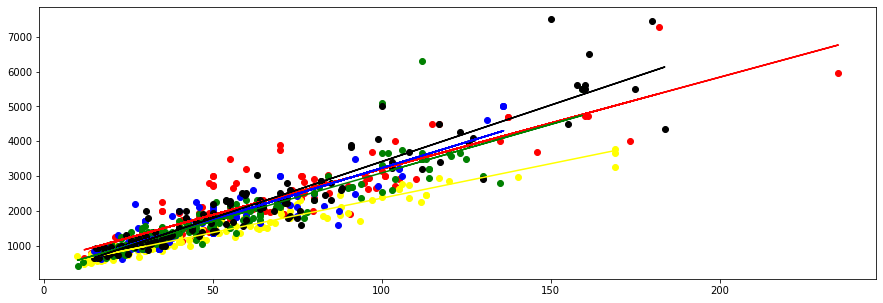

In [8]:
X = house_data[['surface','arrondissement']]
## replace "arrondissement" (type = float) with "arr" (type = str(int(float)))
X["arr"] = X['arrondissement'].map(int).map(str)
X.drop("arrondissement", axis = 1, inplace=True)

y = house_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

## DEFINE MODEL :
grouped = X_train.groupby('arr')
dict_regr_k = {}

## TRAINING arrondissement by arrondissement -> 5 linear regr: 
for key, X_train_k in grouped : 
    y_train_k = y_train[X_train_k.index]
    regr = linear_model.LinearRegression()
    regr.fit(np.matrix(X_train_k["surface"]).T, y_train_k)
    dict_regr_k[key]= regr
    
    plt.scatter(X_train_k["surface"], y_train_k, label=key, color=colors[key] ) 
    ## OVER-FITTED MODEL (just to be sure of the code) :
    reg_k = dict_regr_k[key]
    predicted_price_k = reg_k.predict(np.matrix(X_train_k["surface"]).T)
    plt.plot(X_train_k["surface"], predicted_price_k , color = colors[key])
        
# tmp = pd.DataFrame(y_test).copy()
# tmp["predicted"] = regr.predict(X_test)
# tmp.head(5)


Let us first see graphically what it gives : 

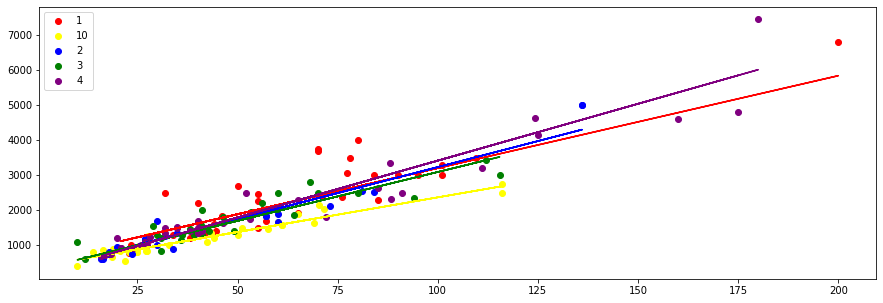

In [9]:
## MODEL PREDICTION ON TEST DATA

index_test = X_test.index
colors = {'1':'red', '2':'blue', '3':'green', '4':'purple', '10':'yellow'}
          
grouped = X_test.groupby('arr')
for key, X_test_k in grouped:
    y_test_k = y_test[X_test_k.index] 
    plt.scatter(X_test_k["surface"], y_test_k, label=key, color=colors[key] ) 
    reg_k = dict_regr_k[key]
    predicted_price_k = reg_k.predict(np.matrix(X_test_k["surface"]).T)
    plt.plot(X_test_k["surface"], predicted_price_k , color = colors[key])
plt.legend()
plt.show()



Let's create a function that, given a sample test of house data, return directly the prediction (thus, that call the right linear regression fitted on the corresponding arrondissement data) : 

In [10]:
### Des bugs dans les fontions ... je vais implémenter en brut

# data = house_data.copy()
# index_test = X_test.index

def multiLR_predict(data, index_test, dict_regr_k): 
    # apply multi-linear regression 
    # return a pd.Series prediction
    ## Extract test sample from data
    Xtest = data["surface"][index_test]
    Xtest["arr"] = data["arrondissement"][index_test].map(int).map(str)
    res = pd.Series(dtype = "float64", index = Xtest.index)
    ## groupe by arrondissement, and call trained linear regression :
    grouped = Xtest.groupby('arr')
    for key, Xtest_k in grouped:
        reg_k = dict_regr_k[key]
        res.loc[Xtest_k.index] = reg_k.predict(np.matrix(Xtest_k).T)
    return(res)

def multiLR_score(data, index_test, dict_regr): 
    # apply multi-linear regression and extract score
    # return a pd.Series prediction
    ## Extract test sample from data
    Xtest = data["surface"][index_test]
    Xtest["arr"] = data["arrondissement"][index_test].map(int).map(str)
    res = {}
    ## groupe by arrondissement, and call trained linear regression :
    grouped = Xtest.groupby('arr')
    for key, Xtest_k in grouped:
        ytest_k = house_data["price"][Xtest_k.index]
        reg_k = dict_regr[key]
        res[key] = reg_k.score(np.matrix(Xtest_k).T, ytest_k)
    return(res)

## TEST AND SCORE : 
# index_test_k = (X_test["arrondissement"]==k).index
# X_test_k = np.matrix(X_test["surface"][app_test_k]).T
# y_test_k = y_test[app_test_k]

    

In [22]:
# np.array(X_test.index)
# house_data["arrondissement", np.array(X_test.index)
house_data["arrondissement"][index_test]
Xtest

,price,arr
511,24.00,4
616,160.00,4
333,30.00,3
161,55.00,1
310,59.83,3
...,...,...
404,12.01,3
315,70.00,3
204,81.10,2
678,18.54,10


In [21]:
## Extract test sample from data
index_test = np.array(X_test.index)
Xtest = X_test.copy()
Xtest["arr"] = house_data["arrondissement"][index_test].map(int).map(str)
## Init scores and predictions : 
scores = {}
predictions = Xtest.drop("price")
# predictions = pd.DataFrame(dtype = "float64", index = Xtest.index)
predictions.columns = ["price", "arr"]
## groupe by arrondissement, and call trained linear regression :
grouped = Xtest.groupby('arr')
for key, Xtest_k in grouped:
    reg_k = dict_regr_k[key]
    predictions["price"][Xtest_k.index] = reg_k.predict(np.matrix(Xtest_k).T)
    predictions["arr"][Xtest_k.index] = key

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 41)

In [ ]:
regr.predict(X_test).shape

In [ ]:
regr = linear_model.LinearRegression()
K = len(np.unique(house_data["arrondissement"])) # number of different arr
list_lr=[]

for j in range(K) :
    # j is the column number in X_train, see above 
    app_in_k_train = np.where(X_train[:,2+j]==1)[0]
    X_train_k = X_train[app_in_k_train,:2]
    y_train_k = y_train[app_in_k_train]
    
    regr.fit(X_train_k, y_train_k)
    
#     app_in_k_test = np.where(X_test[:,2+j]==1)[0]
#     X_test_k = X_test[app_in_k_test,:2]
#     y_test_k = y_test[app_in_k_test]
    
    list_lr.append(regr)

## 3. Combined model : can we train a global linear regression ? 
### 3.1 Introducing the importance of each variable : 


To train our linear regression, we will need to create the $X$ matrix as : 

$$ X = \begin{pmatrix}
1 & loyer & arr_1(1) & arr_2(1) & \dots & arr_12(1)\\
& & &\dots & &  \\
1 & loyer & arr_1(i) & arr_2(i) & \dots & arr_12(i) \\
& & & \dots & &\\
1 & loyer & arr_1(n) & arr_2(n) & \dots & arr_12(n) 
\end{pmatrix} 
$$

Where 
* k = 1 ... K are the arrondissements
* i = 1 ... n are the appartements
* arr_k(i) is a boolean variable and equals to 1 if the $i^{th}$ appartement is the $k^{th}$ arrondissement, 0 otherwise. 

Indeed, the arrondissement information is a categorial info and not a numerical one. In a first approche, we will consider the arrondissement and surface without putting a weight (see after) 

So, we first need to construct the 0-1 submatrice size $k \times n$, denoted A, containing the information about arrondissement. We will first construct it with a loop and then we will use a pandas.Dataframe method to do it more properly :

Even thought the results doesn't seem that bad, I am not happy with this modelisation : I did not control how the arrondissement is important compared to the surface of the appartement. To do it, let's introduce an hyperparemeter $\mu$ that enable me to controle the weight/importance of the categorial and numerical variable. The idea is to set the better (in term of training) $\mu$ such that
<center>price = $\mu$ * surface + (1-$\mu$) * $\mathbb{1}_{\text{arrondissement}} + C^{\text{te}}$   </center>
    
As we know that the surface is really larger that 1, one can imagine that the mu parameter will be  
Note that this code is not optimized at all, but I gave some semantic variables to easy the lecture.

In [ ]:
## BY HAND METHOD : 
K = np.int(max(house_data["arrondissement"]))
n = house_data.shape[0]
A = np.zeros((n,K))

for k in range(K): 
    A[house_data["arrondissement"]==k,k]=1

TODO test unitaire : vérifier que sum(sum(A))==n

In [ ]:
## WITH PANDAS METHOD : 
A = pd.get_dummies(house_data["arrondissement"],prefix="arr")

Concatenate a 1 vector, $A$ and "surface" column of data_house to get $X$

In [ ]:
X = np.concatenate((np.matrix([np.ones(house_data.shape[0]), house_data['surface'].values]),A.T)).T
y = np.matrix(house_data['price']).T

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)


In [ ]:
regr = linear_model.LinearRegression()
K = len(np.unique(house_data["arrondissement"])) # number of different arr
list_lr=[]

for j in range(K) :
    # j is the column number in X_train, see above 
    app_in_k_train = np.where(X_train[:,2+j]==1)[0]
    X_train_k = X_train[app_in_k_train,:2]
    y_train_k = y_train[app_in_k_train]
    
    regr.fit(X_train_k, y_train_k)
    
#     app_in_k_test = np.where(X_test[:,2+j]==1)[0]
#     X_test_k = X_test[app_in_k_test,:2]
#     y_test_k = y_test[app_in_k_test]
    
    list_lr.append(regr)

In [ ]:
## CATEGORICAL VARIABLE MATRIX : 
A = pd.get_dummies(house_data["arrondissement"],prefix="arr")

## MODEL MATRIX WITH HYPERPARAMETER MU : 
y = np.matrix(house_data['price']).T
# semantic variables :
surface = house_data['surface'].values
shift = np.ones(house_data.shape[0])
arrondissement = A.T
      
mu = 0.5                
X_mu = np.concatenate((np.matrix([shift, mu*surface]) , (1-mu)*arrondissement)).T
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)


The issue with this choise is that the train/test sets depend on mu, and it is not our aim. So I think it is a better practice to split the data independantly of mu and modify it after the X_train and X_test. That's what I do now : 

In [ ]:
## CATEGORICAL VARIABLE MATRIX : 
A = pd.get_dummies(house_data["arrondissement"],prefix="arr")

## MODEL MATRIX WITH HYPERPARAMETER MU : 
y = np.matrix(house_data['price']).T
# semantic variables :
surface = house_data['surface'].values
shift = np.ones(house_data.shape[0])
arrondissement = A.T
               
X = np.concatenate((np.matrix([shift, surface]) , arrondissement)).T
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [ ]:
def mu_weigth_on_X0(VarX,Varmu):
    res = VarX.copy()
    res[:,1] = Varmu*res[:,1]
    res[:,2:] = (1-Varmu)*res[:,2:]
    return(res)

def mu_weigth_on_X(VarX,Varmu):
    res = VarX.copy()
    res[:,2:] = Varmu*res[:,2:]
    return(res)

mu = 0.5
X_train_mu = mu_weigth_on_X(X_train,mu)
## TRAINING 
regr = linear_model.LinearRegression() 
regr.fit(X_train_mu, y_train)


So, we can loop on different vaues of mu to set the better model. The differents methods to split the dataset are presented after (Leave One Out, KFold, Cross Validation). I used the sklearn CV routine : 

In [ ]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(regr, X_train_mu, y_train, cv=10)
print(cv_results['test_score'].mean())

In [ ]:
regr = linear_model.LinearRegression() 

mu_values = np.arange(0,10000,10)
reg_scores = []
for mu in mu_values : 
    X_train_mu = X_train.copy()
    X_train_mu[:,2:] = mu*X_train_mu[:,2:]
    #X_train_mu = mu_weigth_on_X(X_train,mu)
#     print(X_train_mu[:3,])
    ## LINEAR REGRESSION :
    #regr.fit(X_train_mu, y_train)
    cv_results = cross_validate(regr, X_train_mu, y_train, cv=10)
    
    reg_scores.append(cv_results['test_score'].mean())

In [ ]:
plt.plot(mu_values,reg_scores,'-o')

In [ ]:
X_train_mu[0,]

In [ ]:
X_train[0,]